# Car Object Detection AI

## Libraries

In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import shutil as sh
import csv

from IPython.display import Image, clear_output, display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import warnings
warnings.simplefilter("ignore", UserWarning)

## Data Creation & Preprocessing

In [2]:
df = pd.read_csv('./data/train_solution_bounding_boxes.csv')
df['image'] = df['image'].apply(lambda x: x.split('.')[0])

1. Split training_imgaes into val and train
2. ./tmp/images have images and ./tmp/labels have xmin, ymin, xmax, ymax values

In [3]:
index = list(set(df.image))
val_index = index[0:len(index)//5] # [0:71]
for name,info in tqdm(df.groupby('image')):
    if name in val_index:
        save_path = 'val/'
    else:
        save_path = 'train/'
    if not os.path.exists('./tmp/labels/'+save_path):
        os.makedirs('./tmp/labels/'+save_path)
    with open('./tmp/labels/'+save_path+name+".txt", 'w+') as file:
        row = info[['xmin','ymin','xmax','ymax']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            file.write(text)
            file.write("\n")
    if not os.path.exists('./tmp/images/'+save_path):
        os.makedirs('./tmp/images/'+save_path)
    sh.copy("./data/training_images/{}.jpg".format(name),'./tmp/images/{}/{}.jpg'.format(save_path,name))

100%|██████████| 355/355 [00:00<00:00, 1091.22it/s]


In [4]:
WIDTH = 676.0
HEIGHT = 380.0

### Create Training, Validation, and Test data

In [5]:
training_data = []
names = []

def create_training_data():
    for img in tqdm(os.listdir('./tmp/images/train/')):
        names.append(img[:-4])

    for n in names:
        img_array = cv2.imread('./tmp/images/train/{}.jpg'.format(n))

        lbl_array = np.loadtxt('./tmp/labels/train/{}.txt'.format(n))
        if lbl_array.shape == (4,):
            lbl_array = np.array([lbl_array])
        # else:
        #     obj_num = lbl_array.shape[0]
            # print(n, obj_num)

        training_data.append([img_array, lbl_array])

create_training_data()

100%|██████████| 355/355 [00:00<00:00, 2654149.59it/s]


In [6]:
val_data = []
names = []

def create_val_data():
    for img in tqdm(os.listdir('./tmp/images/val/')):
        names.append(img[:-4])

    for n in names:
        img_array = cv2.imread('./tmp/images/val/{}.jpg'.format(n))

        lbl_array = np.loadtxt('./tmp/labels/val/{}.txt'.format(n))
        if lbl_array.shape == (4,):
            lbl_array = np.array([lbl_array])
        # else:
        #     obj_num = lbl_array.shape[0]
            # print(n, obj_num)

        val_data.append([img_array, lbl_array])

create_val_data()
print(len(val_data))

100%|██████████| 350/350 [00:00<00:00, 3123417.87it/s]


350


In [7]:
random.shuffle(training_data)
random.shuffle(val_data)

In [8]:
x_train = []
y_train  = []
y_temp = []

for features,label in training_data:
    obj_num = label.shape[0]
    for i in range(obj_num):
        x_train.append(features)
        y_temp.append(label[i])

for i in range(len(y_temp)):
    y_temp[i][0] = y_temp[i][0]
    y_temp[i][1] = y_temp[i][1]
    y_temp[i][2] = y_temp[i][2]
    y_temp[i][3] = y_temp[i][3]

x_train = np.array(x_train).astype('float32')
y_train = np.array(y_temp)

In [9]:
x_val = []
y_val  = []
y_temp = []

for features,label in val_data:
    obj_num = label.shape[0]
    for i in range(obj_num):
        x_val.append(features)
        y_temp.append(label[i])

for i in range(len(y_temp)):
    y_temp[i][0] = y_temp[i][0]
    y_temp[i][1] = y_temp[i][1]
    y_temp[i][2] = y_temp[i][2]
    y_temp[i][3] = y_temp[i][3]

x_val = np.array(x_val).astype('float32')
y_val = np.array(y_temp)

## Training

### Create Model

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dense(units=y_train.shape[1], activation = 'softmax'))

print(model.summary())

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 376, 672, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 188, 336, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 184, 332, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 92, 166, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 244352)            0         
                                         

2022-04-19 16:31:23.095760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-19 16:31:23.095919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# model = Sequential()

# model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(64))
# model.add(Activation('relu'))

# model.add(Dense(4))
# model.add(Activation('sigmoid'))

# print(model.summary())

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train Model

In [13]:
learning_rate = 0.0001
batch_size = 32
num_epochs = 10

In [20]:
print(x_train.shape, y_train.shape)

(559, 380, 676, 3) (559, 4)


In [24]:
print(y_train[1])

[272.9435601 184.5897683 383.0014472 232.0286358]


In [14]:
NAME = 'Car-Object-Detection-{}'.format(int(time.time()))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(NAME))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_data = (x_val, y_val), callbacks=[tensorboard, model_save])

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val, y_val, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

Epoch 1/10


2022-04-19 16:31:25.490612: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-19 16:31:25.771357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: -82930024.0000 - accuracy: 0.2433

2022-04-19 16:31:38.122763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 21s 1s/step - loss: -82930024.0000 - accuracy: 0.2433 - val_loss: -536360832.0000 - val_accuracy: 0.6643
Epoch 2/10
18/18 [==============================] - 13s 717ms/step - loss: -4240051200.0000 - accuracy: 0.6619 - val_loss: -16335144960.0000 - val_accuracy: 0.6643
Epoch 3/10
18/18 [==============================] - 11s 615ms/step - loss: -65894428672.0000 - accuracy: 0.6619 - val_loss: -181955297280.0000 - val_accuracy: 0.6643
Epoch 4/10
18/18 [==============================] - 12s 682ms/step - loss: -498916360192.0000 - accuracy: 0.6619 - val_loss: -1142249226240.0000 - val_accuracy: 0.6643
Epoch 5/10
18/18 [==============================] - 10s 556ms/step - loss: -2501143166976.0000 - accuracy: 0.6619 - val_loss: -4963320725504.0000 - val_accuracy: 0.6643
Epoch 6/10
18/18 [==============================] - 9s 504ms/step - loss: -9310437376000.0000 - accuracy: 0.6619 - val_loss: -16651613372416.0000 - val_accuracy: 0.6643
Epoch 7/10
18/18 [

## Prediction

(1, 380, 676, 3)
uint8


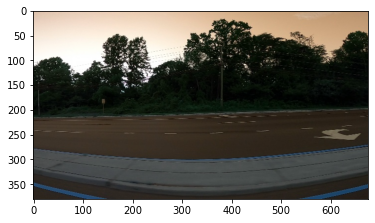

[[0. 0. 1. 0.]]
(0, 0) (1, 0)


In [18]:
testing_names = []
for img in os.listdir('./data/testing_images/'):
    testing_names.append(img)

img_name = testing_names[random.randrange(0, len(testing_names))]
filepath = './data/testing_images/{}'.format(img_name)

raw_image = cv2.imread(filepath)
photo = raw_image.reshape(-1, int(HEIGHT), int(WIDTH), 3)
print(photo.shape)
print(photo.dtype)

prediction = model.predict([photo])

plt.imshow(raw_image)
plt.show()
print(prediction)





point1 = int(prediction[0][0]),int(prediction[0][1])
point2 = int(prediction[0][2]), int(prediction[0][3])
color = (255,0,0)
thickness = 2

print(point1, point2)

# # point1 = 200, 200
# # point2 = 300, 300

# cv2.rectangle(raw_image, point1, point2, color, thickness)
# plt.figure()
# plt.imshow(raw_image)
# plt.imshow(raw_image)